In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
import tensorflow
from keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation,GlobalAveragePooling2D
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score





In [3]:
train_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_train'
test_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/test_set'
val_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_val'

normal


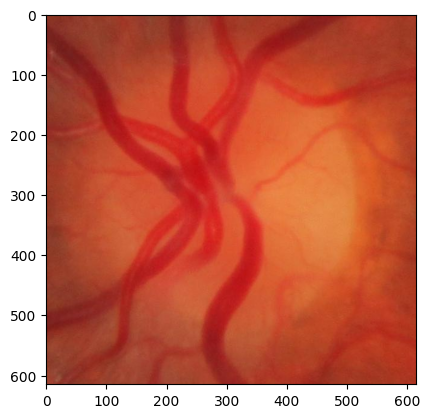

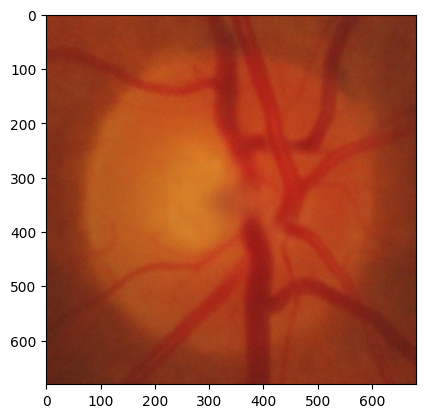

glaucoma


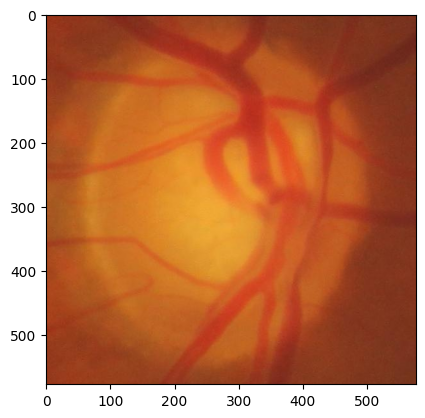

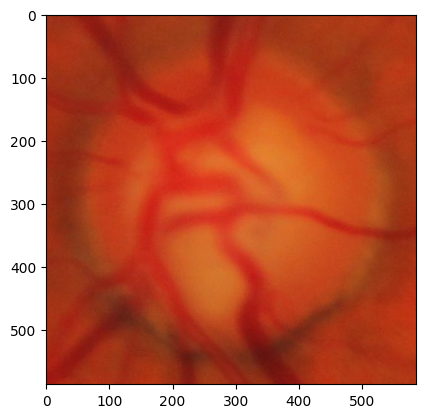

In [4]:
for folder in os.listdir(train_path):
    sub_path = train_path + "/" + folder

    print(folder)
    for i in range(2):
        temp_path = os.listdir(sub_path)[i]
        temp_path = sub_path + "/" + temp_path
        img = mpimg.imread(temp_path)
        imgplot = plt.imshow(img)
        plt.show()

In [5]:
def apply_mask(image, mask, mask_2, line_thickness=2):
    if image is not None and mask is not None and mask_2 is not None:
        # Asegurarse de que image, mask y mask_2 sean matrices de NumPy válidas
        if isinstance(image, np.ndarray) and isinstance(mask, np.ndarray) and isinstance(mask_2, np.ndarray):
            # Verificar si la imagen y las máscaras tienen el mismo tamaño
            if image.shape[:2] != mask.shape[:2]:
                # Redimensionar la máscara 1 para que tenga el mismo tamaño que la imagen
                mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

            if image.shape[:2] != mask_2.shape[:2]:
                # Redimensionar la máscara 2 para que tenga el mismo tamaño que la imagen
                mask_2 = cv2.resize(mask_2, (image.shape[1], image.shape[0]))

            # Asegurarse de que todas las matrices tengan el mismo tipo de dato (CV_8U)
            image = image.astype(np.uint8)
            mask = mask.astype(np.uint8)
            mask_2 = mask_2.astype(np.uint8)

            # Copia de la imagen original
            image_with_contour = image.copy()

            # PRIMERA MASCARA ---------------------------------------------------------------
            # Encuentra el contorno de la máscara 1
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Dibuja una línea roja alrededor del contorno de la máscara 1
            cv2.drawContours(image_with_contour, contours, -1, (0, 0, 255), line_thickness)

            # SEGUNDA MASCARA --------------------------------------------------------------
            # Encuentra el contorno de la máscara 2
            contours_2, _ = cv2.findContours(mask_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Crea una copia de la imagen con la primera máscara ya aplicada
            image_with_both_contours = image_with_contour.copy()

            # Dibuja una línea azul alrededor del contorno de la máscara 2
            cv2.drawContours(image_with_both_contours, contours_2, -1, (255, 0, 0), line_thickness)

            return image_with_both_contours
        else:
            print("image, mask y mask_2 deben ser matrices de NumPy válidas")
    else:
        print("image, mask o mask_2 es None, no se puede aplicar la máscara")


In [6]:
def resize_image(image, size):
    return cv2.resize(image, size)

In [7]:
from google.colab import drive
drive.mount('/content/drive')
import os

mascara_glaucoma_path = '/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/RIM-ONE_segmentation/Glaucoma'
mascara_normal_path = '/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/RIM-ONE_segmentation/Normal'

def imagearray(path, size):
    data = []
    for folder in os.listdir(path):
        sub_path = os.path.join(path, folder)

        for img in os.listdir(sub_path):
            image_path = os.path.join(sub_path, img)
            img_name, img_extension = os.path.splitext(img)  # Separar el nombre del archivo y la extensión

            # Agregar "-Disc-T" al nombre del archivo y eliminar la extensión
            img_name_with_disc_t = img_name + "-1-Disc-T.png"
            img_name_with_cup_t = img_name + "-1-Cup-T.png"

            if img_name_with_disc_t in os.listdir(mascara_glaucoma_path) and img_name_with_cup_t in os.listdir(mascara_glaucoma_path):

                #mascara 1 Disco---------------------------------------
                path_glaucoma_mask = os.path.join(mascara_glaucoma_path, img_name_with_disc_t)

                # Cargar la imagen de máscara
                img_mask = cv2.imread(path_glaucoma_mask)

                # Cargar la máscara
                mascara = cv2.imread(path_glaucoma_mask, cv2.IMREAD_GRAYSCALE)

                #Masacara 2 Cup--------------------------------------
                path_glaucoma_mask_2_cup = os.path.join(mascara_glaucoma_path, img_name_with_cup_t)

                # Cargar la imagen de máscara
                img_mask_2_cup = cv2.imread(path_glaucoma_mask_2_cup)

                # Cargar la máscara
                mascara_2_cup = cv2.imread(path_glaucoma_mask_2_cup, cv2.IMREAD_GRAYSCALE)


                #--------------------------------------------------------------------------------------------
                if img_mask is not None and mascara is not None and mascara_2_cup is not None:
                    mascara = cv2.resize(mascara, size)
                    mascara_2_cup = cv2.resize(mascara_2_cup, size)
                    img_arr = cv2.imread(image_path)

                    if img_arr is not None:
                        img_arr = apply_mask(img_arr, mascara, mascara_2_cup)
                        img_arr = cv2.resize(img_arr, size)



                        data.append(img_arr)
                    else:
                        print(f"Error al cargar la imagen: {image_path}")
                else:
                    print(f"Error al cargar la máscara: {path_glaucoma_mask}")
            else:
                if img_name_with_disc_t in os.listdir(mascara_normal_path) and img_name_with_cup_t in os.listdir(mascara_normal_path):
                     #mascara 1 Disco---------------------------------------
                  path_normal_mask = os.path.join(mascara_normal_path, img_name_with_disc_t)

                  # Cargar la imagen de máscara
                  img_mask = cv2.imread(path_normal_mask)

                  # Cargar la máscara
                  mascara = cv2.imread(path_normal_mask, cv2.IMREAD_GRAYSCALE)

                  #Masacara 2 Cup--------------------------------------
                  path_normal_mask_2_cup = os.path.join(mascara_normal_path, img_name_with_cup_t)

                  # Cargar la imagen de máscara
                  img_mask_2_cup = cv2.imread(path_normal_mask_2_cup)

                  # Cargar la máscara
                  mascara_2_cup = cv2.imread(path_normal_mask_2_cup, cv2.IMREAD_GRAYSCALE)


                  #--------------------------------------------------------------------------------------------
                  if img_mask is not None and mascara is not None and mascara_2_cup is not None:
                      mascara = cv2.resize(mascara, size)
                      mascara_2_cup = cv2.resize(mascara_2_cup, size)
                      img_arr = cv2.imread(image_path)

                      if img_arr is not None:
                          img_arr = apply_mask(img_arr, mascara, mascara_2_cup)
                          img_arr = cv2.resize(img_arr, size)



                          data.append(img_arr)
                      else:
                          print(f"Error al cargar la imagen: {image_path}")
                  else:
                      print(f"Error al cargar la máscara: {path_normal_mask}")

    return data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
size = (224,224)

train = imagearray(train_path, size)
test = imagearray(test_path, size)
val = imagearray(val_path, size)

train


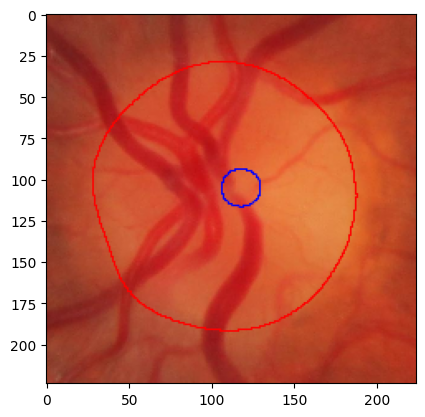

train


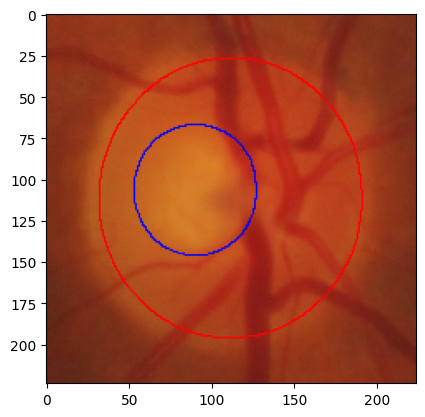

test


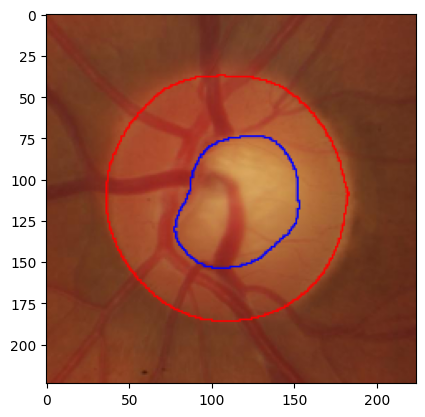

test


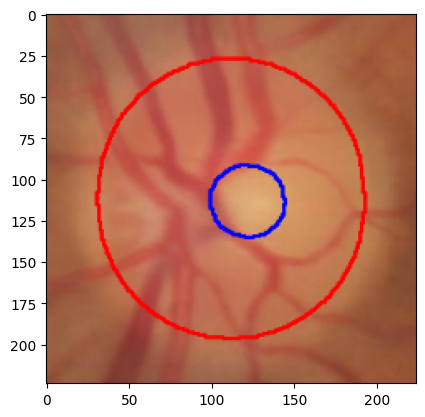

val


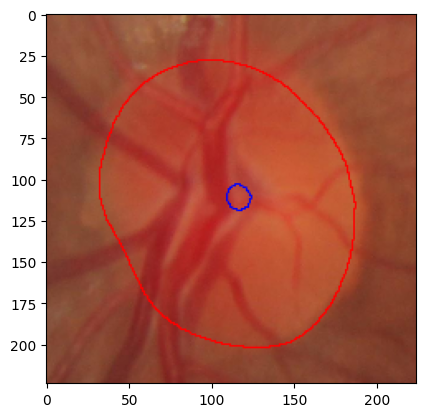

val


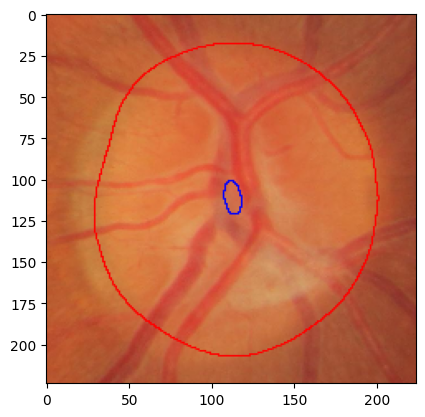

In [9]:
for i in range(2):
    print("train")
    img_rgb = cv2.cvtColor(train[i], cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(img_rgb)
    plt.show()

for i in range(2):
    print("test")
    img_rgb = cv2.cvtColor(test[i], cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(img_rgb)
    plt.show()

for i in range(2):
    print("val")
    img_rgb = cv2.cvtColor(val[i], cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(img_rgb)
    plt.show()

In [10]:
def check_label_correspondence(data_path):
    label_counts = {}
    for root, dirs, files in os.walk(data_path):
        if len(files) > 0:
            label = os.path.basename(root)
            label_counts[label] = len(files)

    return label_counts

In [11]:
label_counts = check_label_correspondence(train_path)
print(label_counts)

{'normal': 156, 'glaucoma': 92}


In [12]:
size = (224, 224)  # Tamaño deseado para las imágenes

train = [cv2.resize(img, size) for img in train]
test = [cv2.resize(img, size) for img in test]
val = [cv2.resize(img, size) for img in val]

In [13]:
x_train = np.array(train)
x_test = np.array(test)
x_val = np.array(val)

In [14]:
x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0

In [15]:
x_train.shape

(248, 224, 224, 3)

In [16]:
def data_class(data_path, size, class_mode):
    datagen = ImageDataGenerator(rescale = 1./255)
    classes = datagen.flow_from_directory(data_path,
                                          target_size = size,
                                          batch_size = 64,
                                          class_mode = class_mode)
    return classes

In [17]:
train_class = data_class(train_path, size, 'sparse')
test_class = data_class(test_path, size, 'sparse')
val_class = data_class(val_path, size, 'sparse')

Found 248 images belonging to 2 classes.
Found 174 images belonging to 2 classes.
Found 63 images belonging to 2 classes.


In [18]:
y_train = train_class.classes
y_test = test_class.classes
y_val = val_class.classes

In [19]:
train_class.class_indices

{'glaucoma': 0, 'normal': 1}

In [20]:
from sklearn.model_selection import KFold

# Concatenar las etiquetas para ambas clases
all_labels_train = np.concatenate([y_train, y_test])
all_labels_test = y_test
all_labels_val = y_val

# Número de folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

MODIFICACION

In [30]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Función para construir el modelo
def build_model():
    vgg = VGG19(input_shape=(224, 224, 3), pooling='avg', include_top=False, weights='imagenet')
    vgg.trainable = False

    x = vgg.output
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=outputs)

    return model

# Función para realizar el ajuste fino
def fine_tune_model(model, train_generator, val_generator):
    model.compile(optimizer=RMSprop(learning_rate=2e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Etapa 1: Congelar la base convolucional
    model.layers[1].trainable = False

    # Etapa 2: Entrenar la parte añadida
    model.fit(train_generator, validation_data=val_generator, epochs=2, batch_size=32)

    # Etapa 3: Descongelar todas las capas en la base convolucional
    model.layers[1].trainable = True

    # Etapa 4: Entrenamiento conjunto
    model.compile(optimizer=RMSprop(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_generator, validation_data=val_generator, epochs=4, batch_size=32)

    return model

# Función para realizar la validación cruzada de 5 pliegues
def cross_validate(model, x_data, y_data):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_index, val_index in skf.split(x_data, y_data):
        x_train, x_val = x_data[train_index], x_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        train_generator = create_generator(x_train, y_train, batch_size=32, augment=True)
        val_generator = create_generator(x_val, y_val, batch_size=32, augment=False)

        fine_tuned_model = build_model()
        fine_tuned_model = fine_tune_model(fine_tuned_model, train_generator, val_generator)

        # Evaluación con AUC
        y_probabilities = fine_tuned_model.predict(val_generator)
        fpr, tpr, _ = roc_curve(y_val, y_probabilities[:, 1])
        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)

    average_auc = np.mean(auc_scores)
    return average_auc

In [31]:
# Cargar tus datos y ejecutar la validación cruzada
x_data = np.concatenate([x_train, x_test])  # Concatenar datos de entrenamiento y prueba
y_data = np.concatenate([y_train, y_test])

result_auc = cross_validate(build_model(), x_data, y_data)
print(f'Average AUC: {result_auc:.4f}')

Epoch 1/2
11/11 [==============================] - 368s 34s/step - loss: 0.6313 - accuracy: 0.6558 - val_loss: 0.5870 - val_accuracy: 0.7176
Epoch 2/2
11/11 [==============================] - 365s 34s/step - loss: 0.6151 - accuracy: 0.6944 - val_loss: 0.5852 - val_accuracy: 0.7176
Epoch 1/4
11/11 [==============================] - 705s 64s/step - loss: 0.6084 - accuracy: 0.6855 - val_loss: 0.5839 - val_accuracy: 0.7176
Epoch 2/4
11/11 [==============================] - 715s 65s/step - loss: 0.6012 - accuracy: 0.6499 - val_loss: 0.5834 - val_accuracy: 0.7176
Epoch 3/4
11/11 [==============================] - 709s 65s/step - loss: 0.6107 - accuracy: 0.6647 - val_loss: 0.5817 - val_accuracy: 0.7176
Epoch 4/4
3/3 [==============================] - 72s 22s/step
Epoch 1/2
11/11 [==============================] - 357s 32s/step - loss: 0.7490 - accuracy: 0.5490 - val_loss: 0.6159 - val_accuracy: 0.7176
Epoch 2/2
11/11 [==============================] - 366s 34s/step - loss: 0.7464 - accuracy: 

3/3 [==============================] - 67s 21s/step
Epoch 1/2
11/11 [==============================] - 360s 32s/step - loss: 1.1074 - accuracy: 0.2811 - val_loss: 0.9994 - val_accuracy: 0.2857
Epoch 2/2
11/11 [==============================] - 369s 34s/step - loss: 0.9911 - accuracy: 0.3343 - val_loss: 0.9884 - val_accuracy: 0.2857
Epoch 1/4
11/11 [==============================] - 716s 65s/step - loss: 1.0724 - accuracy: 0.2840 - val_loss: 0.9720 - val_accuracy: 0.2857
Epoch 2/4
11/11 [==============================] - 715s 65s/step - loss: 1.0015 - accuracy: 0.3432 - val_loss: 0.9642 - val_accuracy: 0.2857
Epoch 3/4
11/11 [==============================] - 715s 65s/step - loss: 1.0024 - accuracy: 0.3077 - val_loss: 0.9553 - val_accuracy: 0.2857
Epoch 4/4
11/11 [==============================] - 715s 66s/step - loss: 1.0238 - accuracy: 0.3107 - val_loss: 0.9474 - val_accuracy: 0.2857


3/3 [==============================] - 73s 22s/step
Average AUC: 0.5888


ESTO ES PARA OTRA PRUEBA:
  

In [21]:



vgg = VGG19(input_shape = (224, 224, 3), pooling=GlobalAveragePooling2D,  include_top = False, weights = 'imagenet')
vgg.trainable = False
x = vgg.output
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(2, activation='softmax')(x)
x = keras.layers.Dropout(0.5)(x)  # Agrega Dropout
model = keras.Model(inputs=vgg.input, outputs=outputs)

# Load the pre-trained VGG19 model
model.load_weights('/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/vgg19_final_weights.h5')

In [22]:
# Tasa de aprendizaje y optimizador para el ajuste fino
optimizer = optimizers.RMSprop(learning_rate=1e-5)

# Compila el modelo para el ajuste fino
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:

# Inicializa el generador de datos
datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode='nearest')


In [26]:
def evaluate_model(trained_model, x_test, y_test):
    y_probabilities = trained_model.predict(x_test)

    # Calcular AUC
    fpr, tpr, _ = roc_curve(y_test, y_probabilities[:, 1])  # Asumiendo clasificación binaria
    auc_score = auc(fpr, tpr)

    # Calcular precisión (accuracy)
    y_pred = np.argmax(y_probabilities, axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    return auc_score, accuracy

# Utiliza esta función para evaluar el modelo después de cargar los pesos
auc_score, accuracy = evaluate_model(model, x_test, y_test)

print(f'AUC: {auc_score:.4f}')
print(f'Accuracy: {accuracy:.4f}')

6/6 [==============================] - 147s 25s/step
AUC: 0.5561
Accuracy: 0.3218
